In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# 한글 폰트 설정 - window, mac
#plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False ## 마이너스 부호 깨짐 방지


# [1] 데이터 불러오기

In [3]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
random_seed = 1106
set_random_seed(random_seed)

In [4]:
## sessions
sessions = pd.read_csv('sessions.csv')
train = pd.read_csv('train_users_2.csv')
train.rename(columns={'id':'user_id'},inplace=True)

In [5]:
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'], format = '%Y%m%d%H%M%S')
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
train['date_first_booking'] = pd.to_datetime(train['date_first_booking'], errors='coerce')

# [2] sessions 전처리 (df)

In [6]:
train_user_ids = set(train['user_id'])

# session 데이터에서 train 데이터에 존재하는 user_id만 필터링하여 사용
df = sessions[sessions['user_id'].isin(train_user_ids)]
df.isnull().sum()

user_id               0
action            51532
action_type      619860
action_detail    619860
device_type           0
secs_elapsed      73815
dtype: int64

In [7]:
# 'NDF'인 경우에는 0으로, 그 외의 경우에는 1로 값을 갖는 바이너리 타겟 열 생성
train['binary_target'] = (train['country_destination'] != 'NDF').astype(int)
df = df.copy()
# df의 각 행에 대해 해당하는 유저 ID의 바이너리 타겟 값을 가져옵니다.
df.loc[:,'binary_target'] = df.loc[:,'user_id'].map(train.set_index('user_id')['binary_target'])
df['binary_target'].mean()

0.44786317409109533

## 유저별 action order 생성
각 유저별 action_order 열에 로그 순서(1~) 입력

In [8]:
df['action_order'] = df.groupby('user_id').cumcount() + 1

## 유저 elapsed time 변경 
이전행부터 현재행까지 측정된 시간 -> 현재 액션의 총 걸린 시간으로 변경  
NaN -> 0 대체

In [9]:
# 한 칸씩 위로 당겨오기
df['secs_elapsed'] = df['secs_elapsed'].shift(-1)
# 유저별 마지막 elapsed time은 측정되지 않았으므로 nan
last_order = df.groupby('user_id').tail(1).index
df.loc[last_order, 'secs_elapsed'] = np.NaN
# 'secs_elapsed' 열의 null 값을 0으로 대체
df['secs_elapsed'].fillna(0, inplace=True)



## action 결측치 처리
-unknown- -> unknown
action: NaN -> unknown  
action_type: NaN -> unknown  
action_detail: NaN -> unknown  


In [10]:
df.loc[df['action_type'] == '-unknown-', 'action_type'] = 'unknown'
df.loc[df['action_detail'] == '-unknown-', 'action_detail'] = 'unknown'

# 'action', 'action_type', 'action_detail' 열의 null 값을 'unknown'으로 대체
df['action'].fillna('error', inplace=True)
df['action_type'].fillna('unknown', inplace=True)
df['action_detail'].fillna('unknown', inplace=True)

df['action_flow'] = df['action'].astype('str') + '+' + df['action_type'].astype('str') + '+' + df['action_detail'].astype('str')

# [3] 액션 EDA

1. 타입별 flow 개수 + 액션(type, detail 1대1 매칭) 그래프
2. 액션 수 및 세션 평균 시간
3. 첫 행동과 마지막 행동
4. 전체 컬럼 별 인원 수와 예약 비율

## 1. 타입별 flow 개수 + 액션(type, detail 1대1 매칭) 그래프

In [11]:
max_length = max(len(str(i)) for i in df['action_type'].unique())

for i in df['action_type'].unique():
    print('action type:',str(i).ljust(max_length),' ','action combination count =',len(df[df['action_type']==i]['action_flow'].unique()))


action type: unknown            action combination count = 245
action type: click              action combination count = 35
action type: data               action combination count = 19
action type: view               action combination count = 52
action type: submit             action combination count = 30
action type: message_post       action combination count = 10
action type: booking_request    action combination count = 2
action type: partner_callback   action combination count = 1
action type: booking_response   action combination count = 1


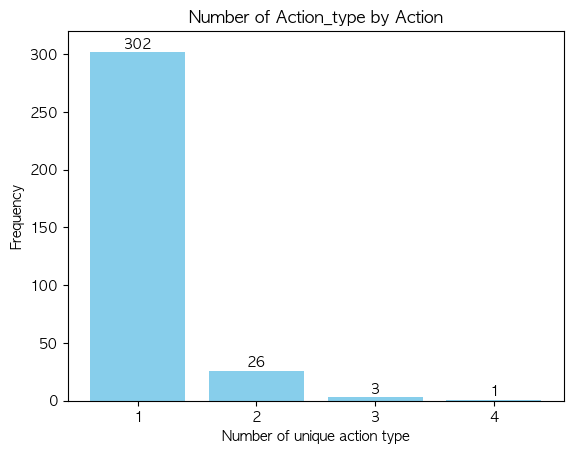

In [12]:
x = df.groupby('action')['action_type'].nunique().value_counts().sort_index()
plt.bar(range(len(x)), x, color='skyblue')  # x값을 인덱스로 설정
plt.xlabel('Number of unique action type')
plt.ylabel('Frequency')
plt.xticks(range(len(x)), x.index)  # xticks를 x.index로 설정하여 숫자 대신에 x값을 표시
plt.ylim(0, max(x) + 1)  # y축 범위 설정

# 각 막대 위에 개수(y값) 표시
for i, v in enumerate(x):
    plt.text(i, v + 3, str(v), ha='center')

plt.ylim(0,320)
plt.title('Number of Action_type by Action')
#plt.savefig('./fplot/action_type.png')
plt.show()

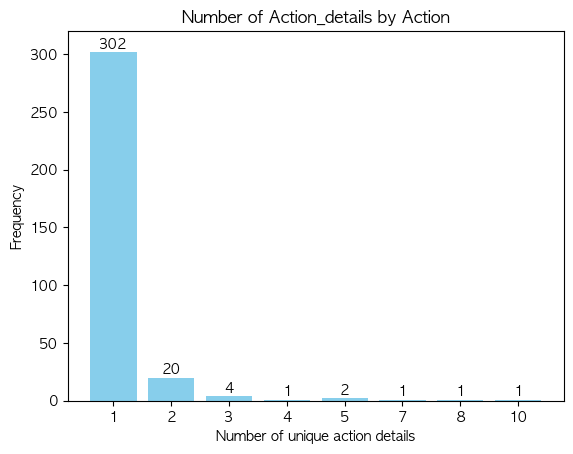

In [13]:
x = df.groupby('action')['action_detail'].nunique().value_counts().sort_index()
plt.bar(range(len(x)), x, color='skyblue')  # x값을 인덱스로 설정
plt.xlabel('Number of unique action details')
plt.ylabel('Frequency')
plt.xticks(range(len(x)), x.index)  # xticks를 x.index로 설정하여 숫자 대신에 x값을 표시
plt.ylim(0, max(x) + 1)  # y축 범위 설정

# 각 막대 위에 개수(y값) 표시
for i, v in enumerate(x):
    plt.text(i, v + 3, str(v), ha='center')

plt.ylim(0,320)
plt.title('Number of Action_details by Action')
#plt.savefig('./fplot/action_detail.png')
plt.show()

## 2. 액션 수 및 세션 평균 시간


In [14]:
from scipy.stats import ttest_ind
# 예약 유저와 비예약 유저 데이터 분리
reserved_users = df[df['binary_target'] == 1]
non_reserved_users = df[df['binary_target'] == 0]

In [15]:
# 예약 유저와 비예약 유저의 행동 횟수 계산
reserved_action_counts = reserved_users.groupby('user_id')['action_order'].max()
non_reserved_action_counts = non_reserved_users.groupby('user_id')['action_order'].max()

# 결과 출력
print("예약한 유저의 마지막 액션의 순서의 평균:", reserved_action_counts.mean())
print("예약하지 않은 유저의 마지막 액션의 순서의 평균:", non_reserved_action_counts.mean())

# 두 그룹 간의 평균 행동 횟수를 비교하는 t-검정
t_stat, p_value_action_count = ttest_ind(reserved_action_counts, non_reserved_action_counts)

print("평균 행동 횟수에 대한 t-검정 결과:")
print("t-statistic:", t_stat)
print("p-value:", p_value_action_count)


예약한 유저의 마지막 액션의 순서의 평균: 86.19750469173559
예약하지 않은 유저의 마지막 액션의 순서의 평균: 67.88725827579317
평균 행동 횟수에 대한 t-검정 결과:
t-statistic: 21.625961336060502
p-value: 2.1472837391699507e-103


Text(0, 0.5, 'Number of users')

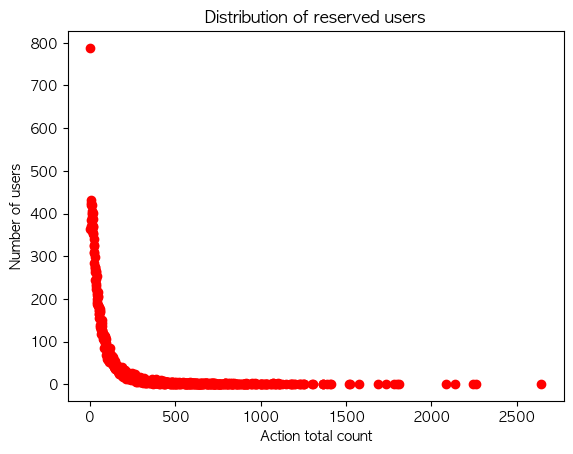

In [16]:

action_count_dist = reserved_action_counts.value_counts()
plt.plot(action_count_dist.index,action_count_dist,'ro')
#plt.xscale('log')

plt.title('Distribution of reserved users')
plt.xlabel('Action total count')
plt.ylabel('Number of users')
#plt.yscale('log')

In [17]:
# 
from scipy.stats import anderson

# Anderson-Darling 검정 수행
result = anderson(reserved_users['secs_elapsed'])

# 결과 출력
print('Statistic:', result.statistic)
print('Critical Values:', result.critical_values)
print('Significance Levels:', result.significance_level)

# 결과 해석
if result.statistic > result.critical_values[2]:
    print('데이터가 정규 분포를 따르지 않습니다.')
else:
    print('데이터가 정규 분포를 따를 수 있습니다.')


Statistic: 668170.067427286
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
데이터가 정규 분포를 따르지 않습니다.


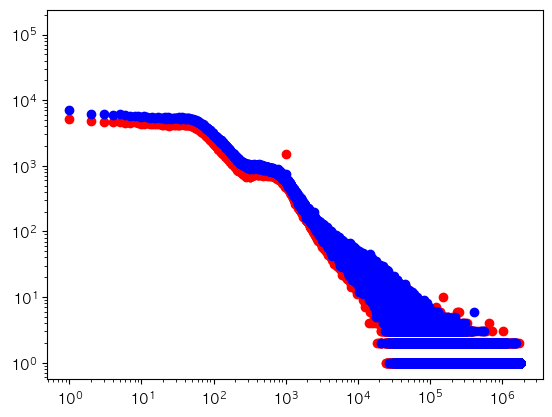

In [18]:
secs_dist = reserved_users['secs_elapsed'].value_counts()
plt.plot(secs_dist.index,secs_dist,'ro')
non_secs_dist = non_reserved_users['secs_elapsed'].value_counts()
plt.plot(non_secs_dist.index,non_secs_dist,'bo')

plt.xscale('log')
plt.yscale('log')

## 3. first, last 액션이 예약과 관련이 있을것이다.

action_flow
show+view+p3                                               2027
personalize+data+wishlist_content_update                   1971
show+unknown+unknown                                       1695
search_results+click+view_search_results                   1561
header_userpic+data+header_userpic                         1412
ajax_refresh_subtotal+click+change_trip_characteristics    1362
similar_listings+data+similar_listings                     1205
index+view+view_search_results                             1108
error+message_post+message_post                             928
dashboard+view+dashboard                                    894
requested+view+p5                                           744
create+submit+create_user                                   734
show+view+user_profile                                      704
confirm_email+click+confirm_email_link                      535
active+unknown+unknown                                      534
update+submit+update_listing

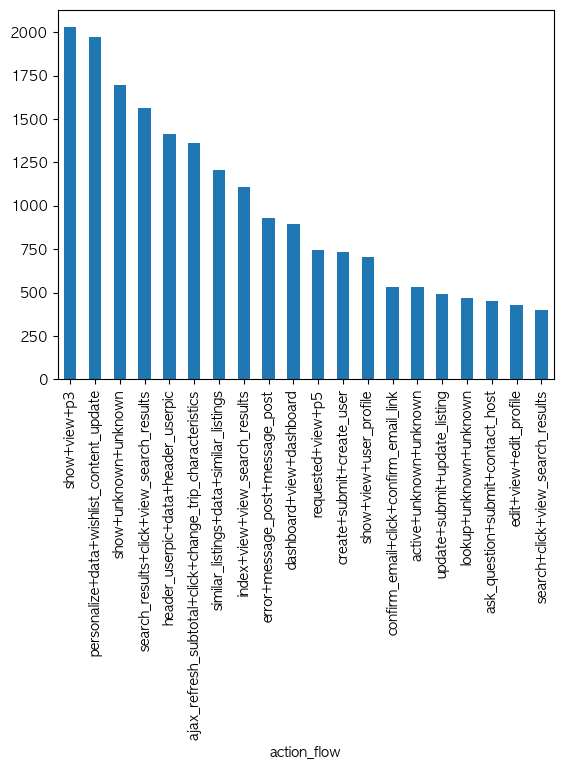

In [19]:
first_action_flow = reserved_users.groupby('user_id')['action_flow'].head(1).value_counts().head(20)
first_action_flow.plot(kind='bar')
first_action_flow
#lt.savefig('./fplot/fitst_reserved_flow.png')

Text(0.5, 1.0, 'booking user action set')

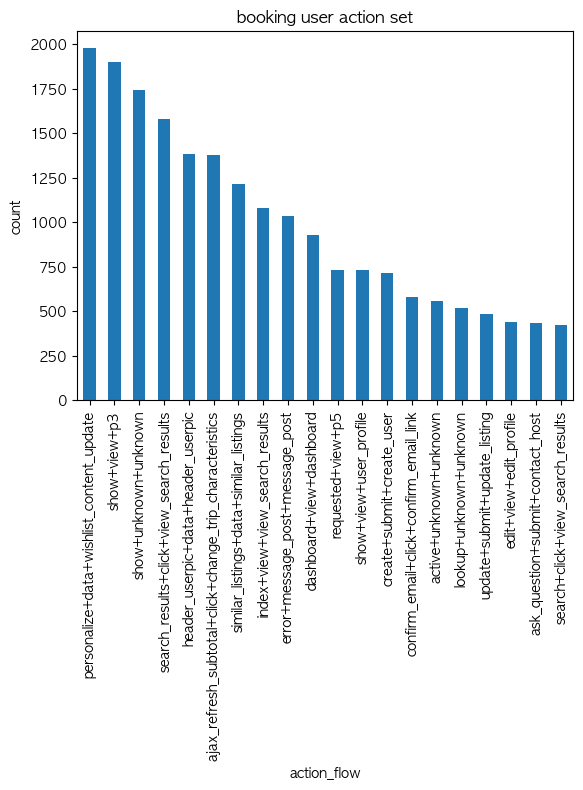

In [20]:
last_action_flow = reserved_users.groupby('user_id')['action_flow'].tail(1).value_counts().head(20)
last_action_flow.plot(kind='bar')
last_action_flow
plt.ylabel('count')
plt.title('booking user action set')
#plt.savefig('./fplot/last_reserved_flow.png')

action
show                     4558
personalize              1971
index                    1810
search_results           1561
header_userpic           1412
create                   1389
ajax_refresh_subtotal    1362
similar_listings         1205
error                     928
dashboard                 894
requested                 881
update                    762
confirm_email             535
active                    534
lookup                    472
ask_question              452
edit                      430
search                    424
authenticate              390
pending                   315
Name: count, dtype: int64

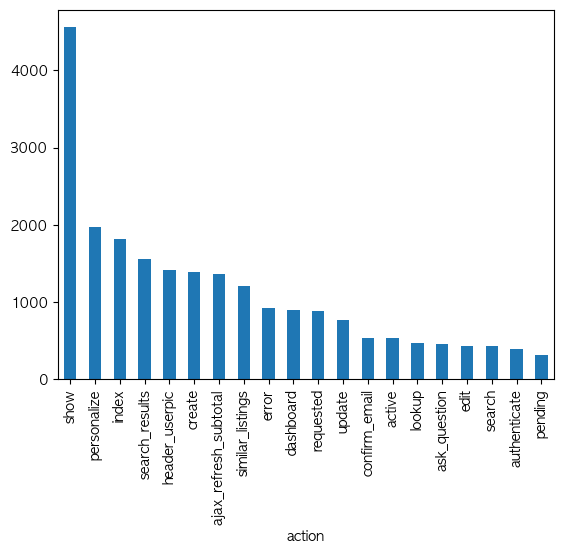

In [21]:
fitst_action = reserved_users.groupby('user_id')['action'].head(1).value_counts().head(20)
fitst_action.plot(kind='bar')
fitst_action

action
show                     4499
personalize              1977
index                    1823
search_results           1580
header_userpic           1387
ajax_refresh_subtotal    1379
create                   1351
similar_listings         1215
error                    1034
dashboard                 932
requested                 902
update                    696
confirm_email             579
active                    559
lookup                    518
search                    440
edit                      440
ask_question              436
authenticate              399
qt2                       311
Name: count, dtype: int64

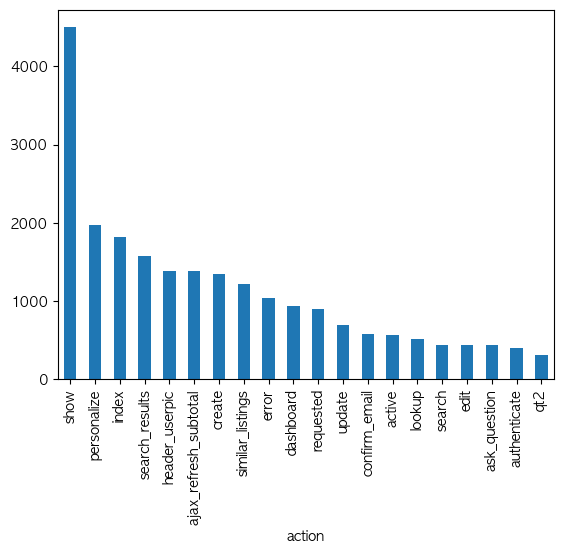

In [22]:
last_action = reserved_users.groupby('user_id')['action'].tail(1).value_counts().head(20)
last_action.plot(kind='bar')
last_action
#plt.savefig('./fplot/last_reserved_action.png')

## 4. 전체 컬럼별 인원 수와 예약 비율

In [23]:
def count_ratio(df,column):
    group_df = df.groupby(column)['binary_target']
    ratio = group_df.mean()
    count = group_df.count()
    count.sort_values(ascending=False,inplace=True)
    sorted_ratio = ratio[count.index]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    # 막대 그래프 (왼쪽 y축)
    count.plot(kind='bar', color='skyblue', alpha=0.7, label='count', ax=ax1)
    ax1.set_ylabel('count')
    #ax1.set_yscale('log')
    # 오른쪽 y축 추가
    ax2 = ax1.twinx()
    sorted_ratio.plot(kind='line', color='red', marker='o', label=' ratio', ax=ax2)
    ax2.set_ylabel('ratio')
    ax2.set_ylim(0,1.2)
    
    # 제목 및 범례 추가
    plt.title('count & booking ratio')
    
    # 그리드 추가
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 범례 위치 조정
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.show()
    
# for i in train_with_sessions_data.columns[6:]:
#     count_ratio(train_with_sessions_data,i)

# [4] train_with_sessions_data (sessions에 user_id를 갖는 train 데이터) 
세션 데이터가 있는 유저는 2014.01.01년부터 존재

1. 나이(43.7%-NaN) 
2. 회원가입 - signup_method(사이트), signup_flow(페이지), signup_app(웹-어플) -> sign_up
3. 접속 경로 - affiliate_channel(채널),  affiliate_provider(채널 제공자) => channel_flow

In [24]:
# sessions 데이터프레임에서 user_id만 추출하여 set으로 변환
sessions_user_ids = set(sessions['user_id'])

# train 데이터프레임에서 sessions에 있는 user_id만을 필터링
train_with_sessions_data = train[train['user_id'].isin(sessions_user_ids)]
train_with_sessions_data

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,binary_target
137021,d1mm9tcy42,2014-01-01,2014-01-01 00:09:36,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,1
137022,yo8nz8bqcq,2014-01-01,2014-01-01 00:15:58,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,0
137023,4grx6yxeby,2014-01-01,2014-01-01 00:16:39,NaT,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,0
137024,ncf87guaf0,2014-01-01,2014-01-01 00:21:46,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,0
137025,4rvqpxoh3h,2014-01-01,2014-01-01 00:26:19,2014-01-02,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-06-30 23:56:36,NaT,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,0
213447,mhewnxesx9,2014-06-30,2014-06-30 23:57:19,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,0
213448,6o3arsjbb4,2014-06-30,2014-06-30 23:57:54,NaT,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,0
213449,jh95kwisub,2014-06-30,2014-06-30 23:58:22,NaT,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF,0


## 1. 나이별 분포 
airbnb 정책: 18세 미만은 예약이 불가능 -> error  
방법: 18세 미만 -> 0으로 대체  
100세 이상 -> unknown으로 묶자 ex 100

In [25]:
train_with_sessions_data[(train_with_sessions_data['age']<19)].groupby('age')['binary_target'].agg(['count','mean'])

,count,mean
age,,
1.0,1,0.000000
2.0,1,0.000000
15.0,3,0.333333
16.0,13,0.076923
17.0,33,0.030303
18.0,190,0.489474


<Figure size 1500x800 with 0 Axes>

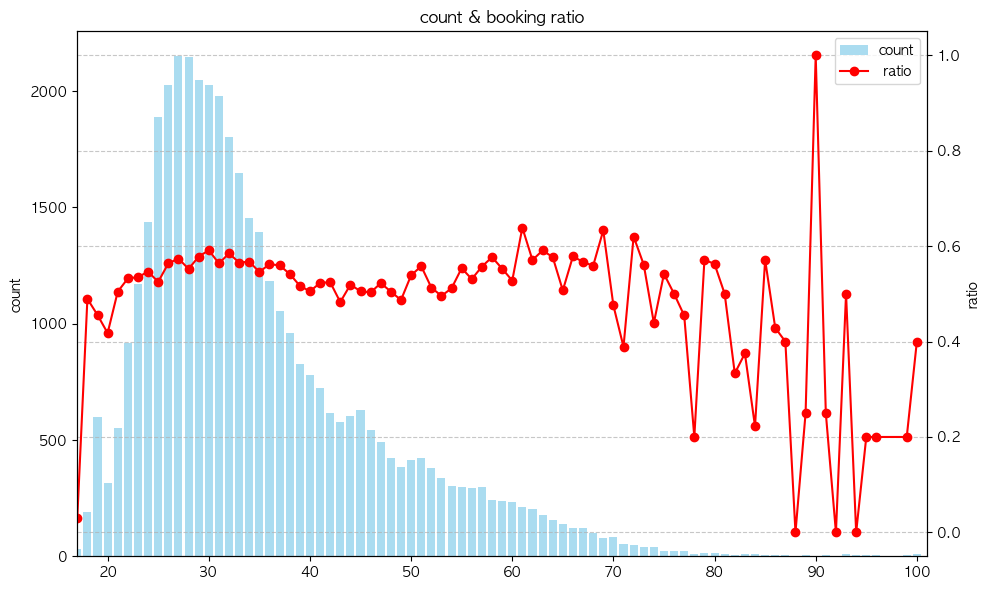

In [26]:
plt.figure(figsize=(15,8))

group_df = train_with_sessions_data[(train_with_sessions_data['age']<101)].groupby('age')['binary_target']
ratio = group_df.mean()
count = group_df.count()

fig, ax1 = plt.subplots(figsize=(10, 6))
# 막대 그래프 (왼쪽 y축)
ax1.bar(count.index,count, color='skyblue', alpha=0.7, label='count')
ax1.set_ylabel('count')
#ax1.set_yscale('log')

# 오른쪽 y축 추가
ax2 = ax1.twinx()
ax2.plot(ratio.index,ratio ,color='red', marker='o', label=' ratio')
ax2.set_ylabel('ratio')

# 제목 및 범례 추가
plt.title('count & booking ratio')
plt.xlim(17,101)

ax2.grid(axis='y', linestyle='--', alpha=0.7)
# 범례 위치 조정
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
plt.xlabel('Age')
plt.tight_layout()
plt.show()

## 2~3. sign_up & channel_flow feature 구성

In [27]:
train_with_sessions_data = train_with_sessions_data.copy()
train_with_sessions_data['sign_up'] = train_with_sessions_data['signup_method'].astype('str') + '+' + train_with_sessions_data['signup_flow'].astype('str') + '+' + train_with_sessions_data['signup_app'].astype('str')
train_with_sessions_data['channel_flow'] = train_with_sessions_data['affiliate_channel'].astype('str') + '+' + train_with_sessions_data['affiliate_provider'].astype('str')

# [5] 그래프로 구성 ( action_flow )
예약 유저의 action_flow 노드, action-flow사이 연결을 edge로 구성
이때, 한 유저의 중복 방문 및 셀프루프 x
 - booking_user_sequences_action: 예약 사용자의 행동 순서를 저장
 - weighted_graph_action: 예약 유저의 행동 그래프
 - top_edges_action: 예약 유저의 상위 100개의 엣지로만 구성된 행동 그래프


In [28]:
def action_reserved_ratio(df,action_column,threshold):
    high_action_list = []
    # 'action'을 기준으로 그룹화하여 평균값 계산
    grouped_actions = df.groupby(action_column)['binary_target'].agg(['count', 'mean'])
    
    # 평균값이 threshold를 넘는 action 정보 필터링하여 리스트에 추가
    for action, values in grouped_actions.iterrows():
        count = values['count']
        ratio = values['mean']
        if ratio > threshold:
            high_action_list.append((action,count,ratio))
    # high_action_list를 count와 ratio에 따라 내림차순으로 정렬
    sorted_high_action_list = sorted(high_action_list, key=lambda x: (x[2], x[1]), reverse=True)
    for action,count,ratio in sorted_high_action_list:
        print(f'count = {int(count):d}, ratio = {ratio:.2f}, action = {action}')
    return sorted_high_action_list

In [29]:
action_flow_group = action_reserved_ratio(df,'action_flow',0.5)

count = 157, ratio = 1.00, action = guest_booked_elsewhere+message_post+message_post
count = 80, ratio = 1.00, action = email_itinerary_colorbox+unknown+unknown
count = 56, ratio = 1.00, action = add_guests+unknown+unknown
count = 11, ratio = 1.00, action = create+submit+create_alteration_request
count = 9, ratio = 1.00, action = respond+submit+respond_to_alteration_request
count = 6, ratio = 1.00, action = open_hard_fallback_modal+unknown+unknown
count = 5, ratio = 1.00, action = acculynk_bin_check_success+unknown+unknown
count = 5, ratio = 1.00, action = acculynk_load_pin_pad+unknown+unknown
count = 5, ratio = 1.00, action = acculynk_session_obtained+unknown+unknown
count = 4, ratio = 1.00, action = acculynk_pin_pad_inactive+unknown+unknown
count = 3, ratio = 1.00, action = airbrb+unknown+unknown
count = 3, ratio = 1.00, action = guest_billing_receipt+unknown+unknown
count = 2, ratio = 1.00, action = confirm_email+unknown+unknown
count = 2, ratio = 1.00, action = friend_listing+unkno

In [30]:
action_group = action_reserved_ratio(df,'action',0.5)

count = 157, ratio = 1.00, action = guest_booked_elsewhere
count = 80, ratio = 1.00, action = email_itinerary_colorbox
count = 56, ratio = 1.00, action = add_guests
count = 9, ratio = 1.00, action = respond
count = 6, ratio = 1.00, action = open_hard_fallback_modal
count = 5, ratio = 1.00, action = acculynk_bin_check_success
count = 5, ratio = 1.00, action = acculynk_load_pin_pad
count = 5, ratio = 1.00, action = acculynk_session_obtained
count = 4, ratio = 1.00, action = acculynk_pin_pad_inactive
count = 3, ratio = 1.00, action = airbrb
count = 3, ratio = 1.00, action = guest_billing_receipt
count = 2, ratio = 1.00, action = friend_listing
count = 2, ratio = 1.00, action = print_confirmation
count = 2, ratio = 1.00, action = signup_weibo
count = 1, ratio = 1.00, action = ajax_special_offer_dates_available
count = 1, ratio = 1.00, action = deauthorize
count = 1, ratio = 1.00, action = desks
count = 1, ratio = 1.00, action = envoy_bank_details_redirect
count = 1, ratio = 1.00, action = 

In [31]:
booking_user_sequences_action = {}

booking_df = df[df['binary_target']==1]
for user_id, group in booking_df.groupby("user_id"):
    actions = list(zip(group["action_order"], group['action']))
    actions.sort(key=lambda x: x[0])  # 순서순으로 정렬
    booking_user_sequences_action[user_id] = actions

weighted_graph_action = {}  

# 각 유저의 예약 시퀀스를 순회하면서 엣지를 구성 -> 하나의 유저가 이동한 path를 edge weight +1 
for user_id, actions in booking_user_sequences_action.items():
    visited_edges = set()  # 해당 유저가 방문한 엣지를 추적하기 위한 집합 생성
    for i in range(len(actions) - 1):
        current_action = actions[i][1]
        next_action = actions[i + 1][1]
        edge = (current_action, next_action)
        if edge[0] == edge[1]:
            continue
        if edge not in visited_edges:  # 해당 유저가 이 엣지를 처음 지나가는 경우에만 가중치 1 증가
            if edge in weighted_graph_action:
                weighted_graph_action[edge] += 1  # 해당 엣지의 가중치 1 증가
            else:
                weighted_graph_action[edge] = 1  # 새로운 엣지인 경우 가중치를 1로 초기화
            visited_edges.add(edge)  # 해당 엣지를 방문했음을 표시

In [32]:
weighted_graph_action

{('index', 'dashboard'): 2314,
 ('dashboard', 'header_userpic'): 2939,
 ('header_userpic', 'dashboard'): 2937,
 ('dashboard', 'callback'): 285,
 ('callback', 'error'): 28,
 ('error', 'pending'): 1930,
 ('pending', 'requested'): 1820,
 ('requested', 'travel_plans_current'): 1565,
 ('travel_plans_current', 'show'): 978,
 ('show', 'ajax_refresh_subtotal'): 11056,
 ('ajax_refresh_subtotal', 'show'): 11138,
 ('show', 'similar_listings'): 10036,
 ('similar_listings', 'confirm_email'): 464,
 ('confirm_email', 'show'): 1081,
 ('show', 'personalize'): 15062,
 ('personalize', 'show'): 15126,
 ('show', 'dashboard'): 2005,
 ('dashboard', 'personalize'): 660,
 ('personalize', 'similar_listings'): 4330,
 ('similar_listings', 'show'): 10117,
 ('show', 'index'): 9673,
 ('index', 'show'): 9686,
 ('similar_listings', 'ajax_refresh_subtotal'): 11079,
 ('show', 'search_results'): 6770,
 ('search_results', 'index'): 6032,
 ('index', 'personalize'): 9317,
 ('social_connections', 'payment_methods'): 72,
 ('p

In [33]:
# edge 개수 출력
edge_count_action = len(weighted_graph_action)
print("Total number of edges:", edge_count_action)

# 가중치를 기준으로 내림차순으로 정렬된 엣지를 가져옵니다.
sorted_edges_action = sorted(weighted_graph_action.items(), key=lambda x: x[1], reverse=True)

# 상위 100개의 엣지를 선택합니다.
top_edges_action = sorted_edges_action[:100]

print("Top 100 edges:")
for edge, weight in top_edges_action:
   print(f"Edge: {edge}, Weight: {weight}")
top_edges_action = dict(top_edges_action)

Total number of edges: 13521
Top 100 edges:
Edge: ('personalize', 'show'), Weight: 15126
Edge: ('show', 'personalize'), Weight: 15062
Edge: ('ajax_refresh_subtotal', 'show'), Weight: 11138
Edge: ('similar_listings', 'ajax_refresh_subtotal'), Weight: 11079
Edge: ('show', 'ajax_refresh_subtotal'), Weight: 11056
Edge: ('ajax_refresh_subtotal', 'similar_listings'), Weight: 11033
Edge: ('similar_listings', 'show'), Weight: 10117
Edge: ('show', 'similar_listings'), Weight: 10036
Edge: ('index', 'show'), Weight: 9686
Edge: ('show', 'index'), Weight: 9673
Edge: ('index', 'personalize'), Weight: 9317
Edge: ('personalize', 'index'), Weight: 9285
Edge: ('search_results', 'show'), Weight: 6784
Edge: ('show', 'search_results'), Weight: 6770
Edge: ('search_results', 'index'), Weight: 6032
Edge: ('index', 'search_results'), Weight: 5996
Edge: ('create', 'header_userpic'), Weight: 5697
Edge: ('header_userpic', 'create'), Weight: 5557
Edge: ('ajax_refresh_subtotal', 'personalize'), Weight: 5532
Edge: (

## action_flow score
그래프 구성은 예약 사용자를 기반으로 구성, 모든 사용자를 대상으로 top edge를 지나간 수를 score로 feature로 구성

모든 유저에 대해서 점수 계산을 진행하여 시간이 오래 걸립니다. <- 코드 최적화 필요

그래프 시각화 부분에 필요하지 않아 주석 처리

In [35]:
# # action score feature 계산 및 추가

# df['action_score'] = 0

# user_sequences_action = {} # 모든 사용자에 대한 행동 순서 정보

# for user_id, group in df.groupby("user_id"):
#     actions = list(zip(group["action_order"], group['action']))
#     actions.sort(key=lambda x: x[0])  # 순서순으로 정렬
#     user_sequences_action[user_id] = actions


# for user_id, actions in user_sequences_action.items():
#     score=0
#     visited_edges = set()
#     for i in range(len(actions)-1):
#         current_action = actions[i][1]
#         next_action = actions[i + 1][1]
#         edge = (current_action, next_action)
#         if edge not in visited_edges:  # 해당 유저가 이 엣지를 처음 지나가는 경우에만 가중치 1 증가
#             if edge in top_edges_action: # top_edges_action: 예약 유저 상위 edge graph 경로
#                 score += 1
#             visited_edges.add(edge)  # 해당 엣지를 방문했음을 표시
#     df.loc[df['user_id']==user_id,'action_score']=score


In [36]:
# # 액션 점수 시각화 (예약 / 미예약)
# reserv_score = train_last_order[train_last_order['binary_target']==1]['action_score'].value_counts()
# x,y=reserv_score.index, reserv_score/sum(reserv_score)
# plt.plot(x,y,'ro', label='Booked')

# non_reserv_score = train_last_order[train_last_order['binary_target']==0]['action_score'].value_counts()
# x1,y1=non_reserv_score.index, non_reserv_score/sum(non_reserv_score)
# plt.plot(x1,y1,'bo',label='Not booked')

# plt.legend(loc='best')
# plt.xlabel('score')
# plt.ylabel('density')

# [6] 그래프 시각화

In [38]:
import networkx as nx
# 그래프 생성
G = nx.DiGraph() 

# 노드와 엣지 추가
for edge, weight in weighted_graph_action.items():  # 여기 weighted_graph_action 자리에 위에서 생성한 top_edges_action을 넣으면 크기 조절 가능
    G.add_edge(edge[0], edge[1], weight=weight)

print(f'그래프의 노드 수: {len(list(G.nodes))}')

그래프의 노드 수: 303


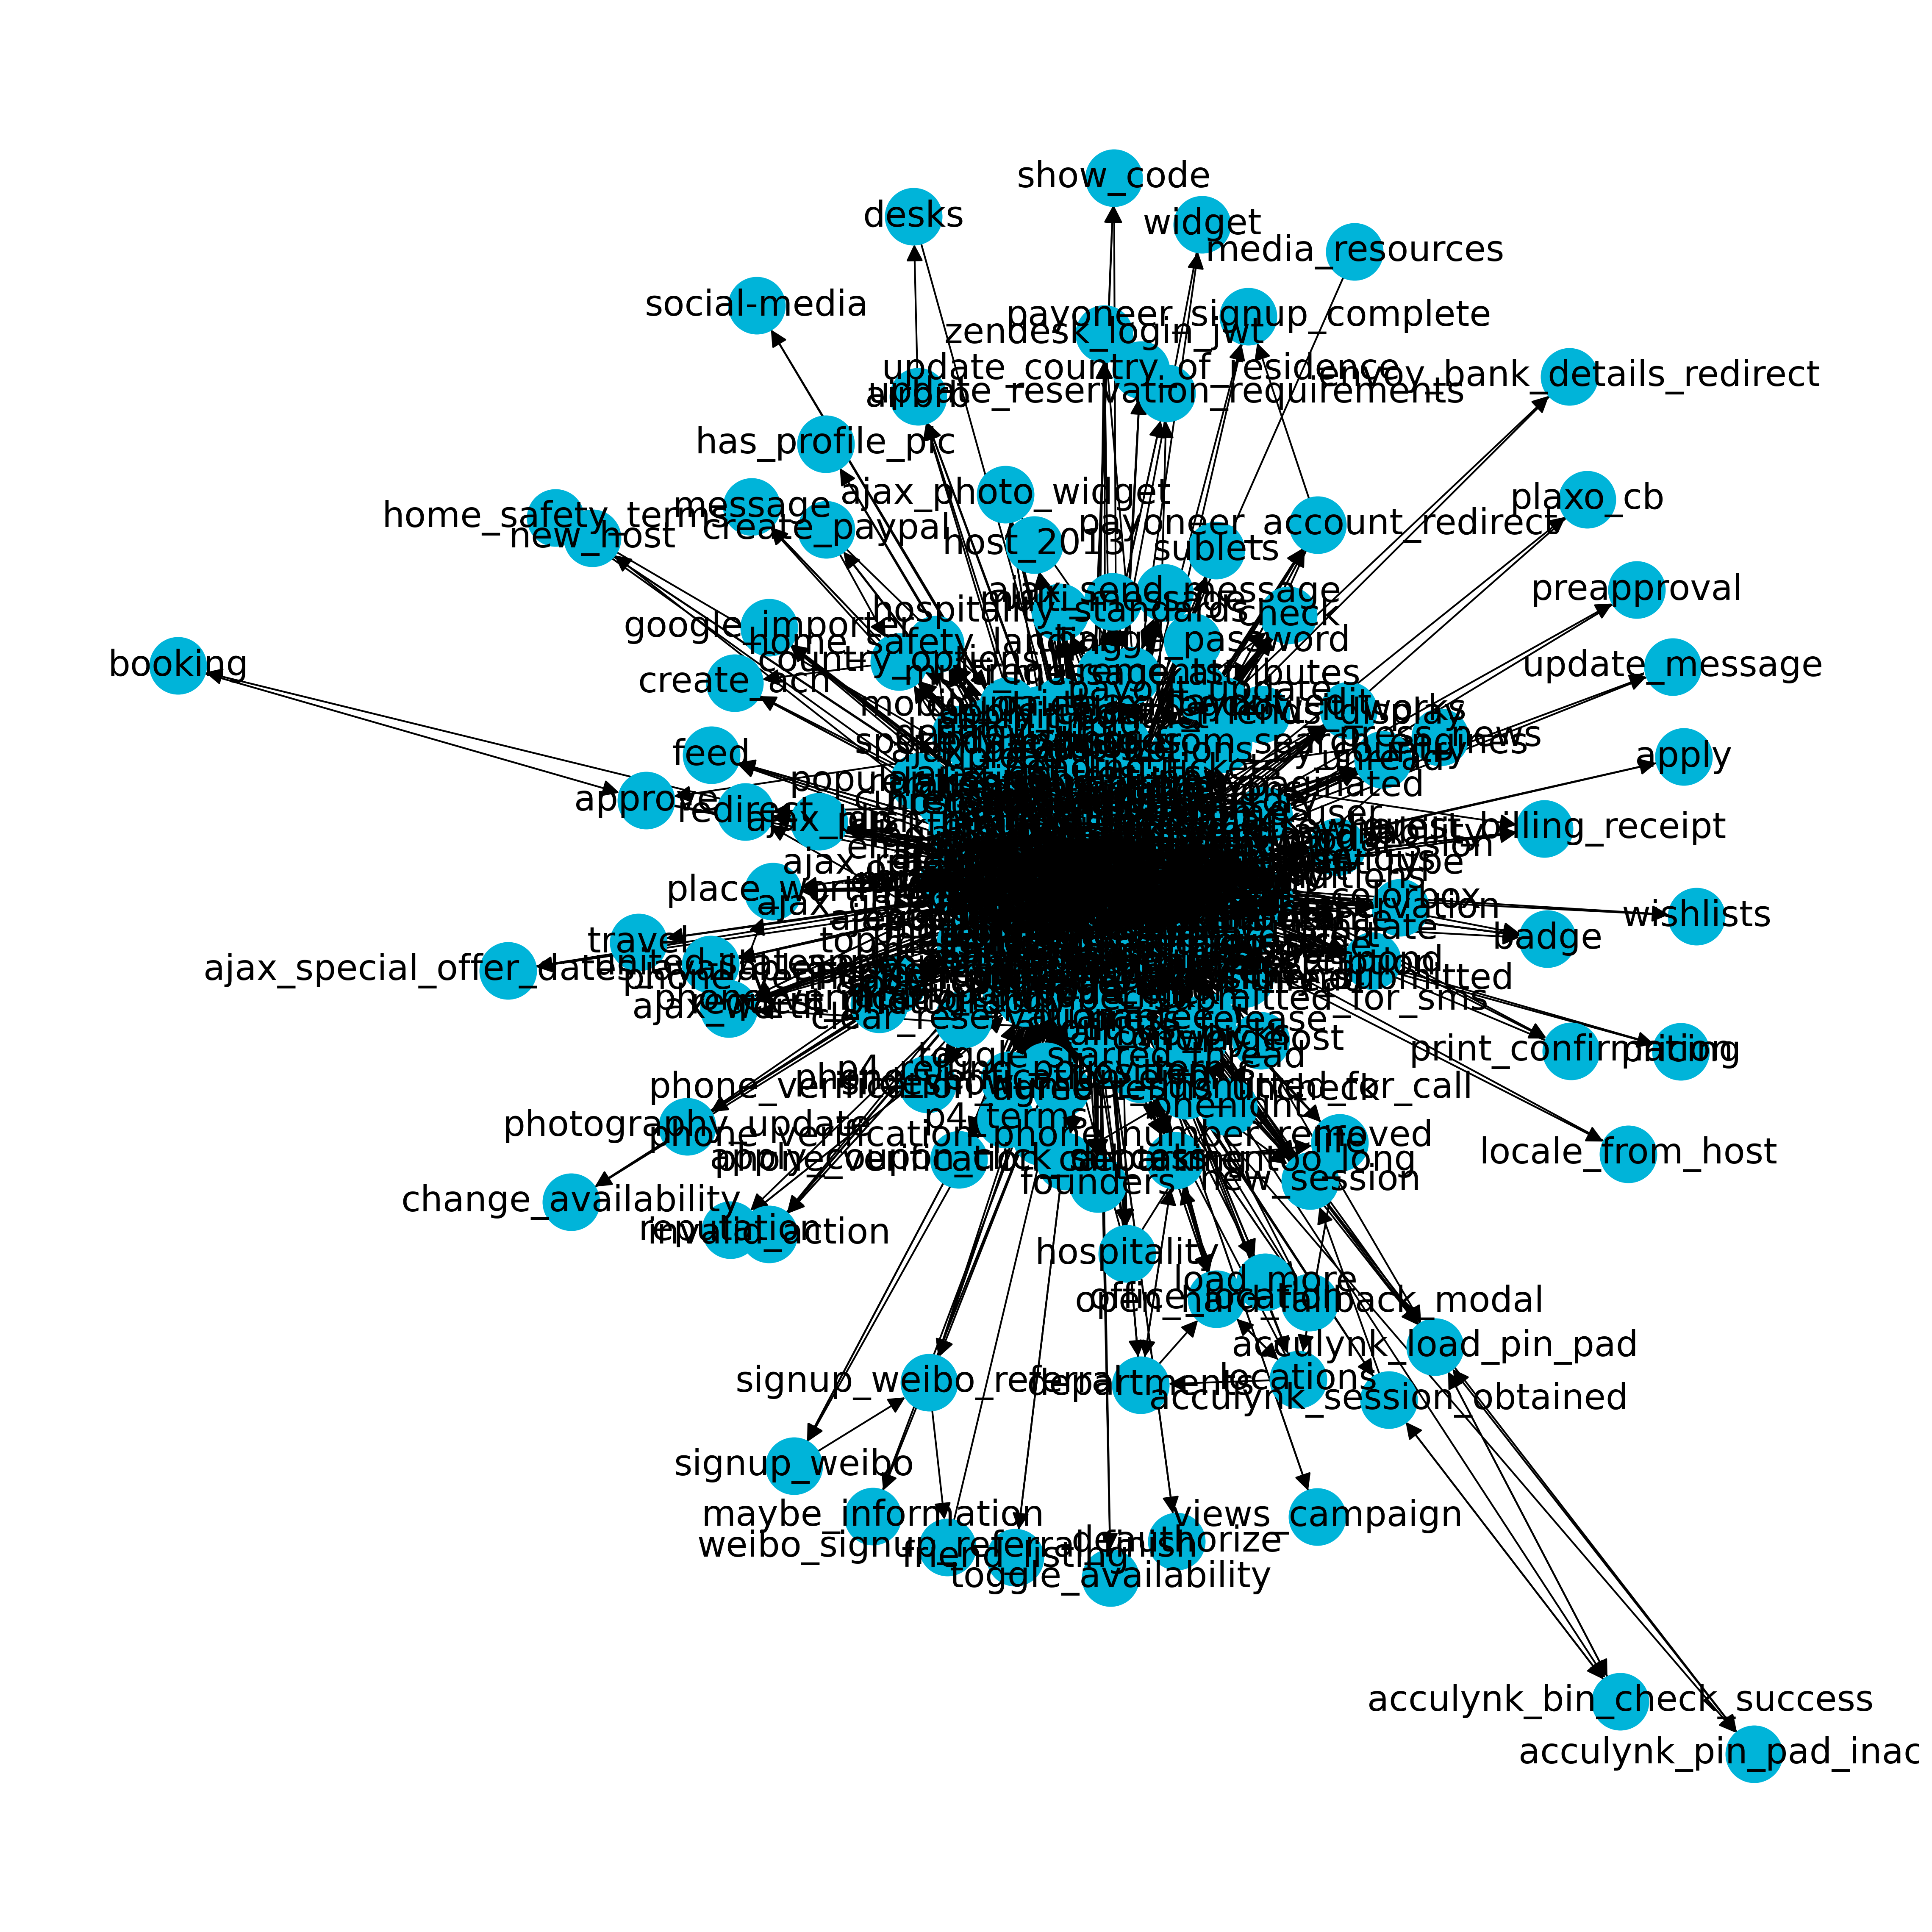

In [62]:
# 시각화 셋팅: spring_layout으로 그래프가 펼쳐지는 정도 조절(k)
# 노드의 연결 선 수에 따라 노드 크기 조절(node_size)
# 링크의 가중치가 클수록 굵게 표시(edge_weights)

plt.figure(figsize=(15,15), dpi=300)
# 그래프 시각화
pos = nx.spring_layout(G,k=0.1)  # k: 그래프의 거리 조절


# 노드의 degree에 따른 크기 계산
node_sizes = [d * 200 for n, d in G.degree()]

# 엣지 가중치 가져오기
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
# 엣지 가중치 변환
transformed_weights = [custom_weight_transform(weight) for weight in edge_weights]
#labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


nx.draw(G, pos, with_labels=True, node_size=1000,node_color='#00b4d9',arrowsize=20, font_size=20, width=1)

#plt.savefig('./fplot/graph_tol33nodes.png')
plt.show()

In [40]:
# 네트워크x 에서 사용하는 함수
list(G.nodes)
H = G.to_undirected()
list(nx.connected_components(H))
#G.remove_nodes_from(['ajax_image_upload', 'profile_pic'])
H = G.to_undirected()
list(nx.connected_components(H))

[{'10',
  '11',
  '12',
  '15',
  'about_us',
  'account',
  'acculynk_bin_check_success',
  'acculynk_load_pin_pad',
  'acculynk_pin_pad_inactive',
  'acculynk_session_obtained',
  'active',
  'add_guests',
  'add_note',
  'agree_terms_check',
  'agree_terms_uncheck',
  'airbnb_picks',
  'airbrb',
  'ajax_check_dates',
  'ajax_get_referrals_amt',
  'ajax_get_results',
  'ajax_google_translate',
  'ajax_google_translate_description',
  'ajax_google_translate_reviews',
  'ajax_image_upload',
  'ajax_ldp',
  'ajax_lwlb_contact',
  'ajax_payout_edit',
  'ajax_payout_options_by_country',
  'ajax_photo_widget',
  'ajax_photo_widget_form_iframe',
  'ajax_price_and_availability',
  'ajax_referral_banner_experiment_type',
  'ajax_referral_banner_type',
  'ajax_refresh_subtotal',
  'ajax_send_message',
  'ajax_special_offer_dates_available',
  'ajax_statsd',
  'ajax_worth',
  'apply',
  'apply_code',
  'apply_coupon_click',
  'apply_coupon_click_success',
  'apply_coupon_error',
  'apply_coupon